In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import sklearn
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from scipy.stats import spearmanr, pearsonr
import scipy.stats
import random

import warnings
warnings.filterwarnings('ignore')

In [26]:
num_task = 3

from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth = 10, random_state = 2404)

gvar = 1e-13

# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()



In [3]:
def genSine(low, high, count):
    noise_mean = 0
    noise_variance = 0.01
    x = np.linspace(low, high, num=count)
    y = np.sin(x)+np.random.normal(noise_mean, noise_variance, count)
    return x.reshape((count,1)), y

data_x, data_y = genSine(0, 2*np.pi, 100)

Data = pd.DataFrame(data_x )
Data.columns = ['x']
Data['y'] = data_y
Data_train = Data.sample(frac=0.5, random_state=2404)

X = Data_train['x']
X  = X.values.reshape((len(X), 1))
Y = Data_train['y']



In [20]:
data_x, data_y = genSine(0, 2*np.pi, 15)

Data = pd.DataFrame(data_x )
Data.columns = ['x']
Data['y'] = data_y

Data.to_csv('Train.csv')

In [21]:
data_x, data_y = genSine(0, 2*np.pi, 200)

Data = pd.DataFrame(data_x )
Data.columns = ['x']
Data['y'] = data_y

Data.to_csv('Test.csv')

In [24]:
def getPrediction(X, Y, X1):
    gp = GaussianProcessRegressor(kernel=kernels.DotProduct(), optimizer='fmin_l_bfgs_b' , alpha=1e-10, normalize_y=True)
    gp.fit(X, Y)
    return gp.predict(X1)

def kernelfunction(a, b):
    return  np.dot(a, b) + 1


def getFullCorrelation(X, T, Y, num_t):
    PredictionFunctions = np.zeros((len(X) , num_t ))
    Correlations = np.zeros((num_t, num_t))
    if (Correlations.shape[0] != num_t ):
        print(Correlations.shape[0], num_t)
        print('ERROR - NUMBER OF TASKS NOT MATCHING- getFULLCorr !!!')
        return 0
    for t in range(0, num_t):
        X_t = X[T == t]
        Y_t = Y[T == t]
        PredictionFunctions[:, t] = getPrediction(X_t, Y_t, X)
    for i in range(0, num_t):
        for j in range(i, num_t):
            Correlations[i, j] = np.cov(PredictionFunctions[:, i], PredictionFunctions[:, j])[0, 1]
            Correlations[j , i] = Correlations[i, j]
    return PredictionFunctions, Correlations


def MTGPPredict(x_new, t_new, X, T, alpha, Cn_inv, Correlations, sigma2):
    N = len(X)
    Knew = np.zeros(N)
    for i in range(N):
        Knew[i] = kernelfunction(x_new, X[i])*Correlations[t_new , T[i]]
    mean = np.dot(Knew, alpha)
    var1 = np.dot(np.dot(Knew, Cn_inv) , Knew)
    var =  kernelfunction(x_new, x_new)*Correlations[t_new , t_new] + sigma2 - var1
    return mean, var



def MTGP(X, T, Y, X_pred, T_pred, Correlations , sigma2 , num_task):
    if (Correlations.shape[0] != num_task):
        print(Correlations.shape[0], num_task)
        print('ERROR - NUMBER OF TASKS NOT MATCHING !!!')
        return 0
    
    N = len(X)    
    Cn = np.zeros((N, N))
    
    for i in range(0, N):
        for j in range(i, N):
            Cn[i, j] = kernelfunction(X[i],  X[j])*Correlations[T[i] , T[j]]
            Cn[j , i] = Cn[i , j]
    Cn = Cn + sigma2*np.identity(N)
    
    Cn_inv = np.linalg.inv(Cn)
    alpha = np.dot(Cn_inv, Y)
    
    Y_pred_mean = np.zeros(len(X_pred))
    Y_pred_var = np.zeros(len(X_pred))
    
    for i in range(len(X_pred)):
        Y_pred_mean[i], Y_pred_var[i] = MTGPPredict(X_pred[i] , T_pred[i] , X, T,alpha, Cn_inv, Correlations , sigma2 )
    return Y_pred_mean, Y_pred_var



def getProb(Y_true, Y_pred_mean, Y_pred_var):
    prob = np.zeros(len(Y_true))
    for i in range(len(Y_true)):
        p = scipy.stats.norm(Y_pred_mean[i], Y_pred_var[i]).pdf(Y_true[i])
        prob[i] = p 
    return prob
    

def getMTGPTask(X, curr_T, Y , sigma2, num_task):
    PredictionFunctions, Correlations = getFullCorrelation(X, curr_T, Y, num_task)
    X_pred = np.repeat(X, num_task)
    T_pred = np.repeat(np.repeat([np.arange(num_task)], len(X), axis=0), 1)
    Y_pred_mean, Y_pred_var = MTGP(X, curr_T, Y, X_pred, T_pred, Correlations , sigma2 , num_task)
    Y_true = np.repeat(np.array(Y), num_task)
    Prob_Task = getProb(Y_true, Y_pred_mean, Y_pred_var)
    new_Tasks = np.zeros(len(X))
    for i in range(len(X)):
        new_Tasks[i] = np.argmax(Prob_Task[ i*num_task : (i+1)*num_task ])
    return new_Tasks

def MakeTask(T):
    dictionary = dict( zip(list(set(T)) , np.arange(len(set(T))))  )
    for i in range(len(T)):
        T[i] = dictionary[T[i]]
    return T
        

def MTGPSolver(X, T, Y, sigma2, num_task, num_iter):
    for i in range(num_iter):
        T = MakeTask(T)
        T = getMTGPTask(X, T, Y, sigma2, len(set(T)) )
        T = T.astype(int)
#         clf.fit(X, T)
#         T  = clf.predict(X)
        print(T)
        T = MakeTask(T)
        num_task = len(set(T))
        PredictionFunctions, Correlations = getFullCorrelation(X, T, Y, num_task)
        Y_pred_mean, Y_pred_var = MTGP(X, T, Y, X, T, Correlations , gvar , num_task)
        Result = pd.DataFrame(Y_pred_mean)
        Result['True'] = np.array(Y)
        Result.columns = ['pred', 'True']
        diff = Result['pred'] - Result['True']
        loss = math.sqrt(np.dot(diff, diff)/len(Result['pred']))
        print(loss)
        fr =pd.DataFrame({'class' : T, 'value': Y_pred_mean, 'input' : X[:, 0]})
        plotPoints(fr)
        # plotLine(fr)
    return T


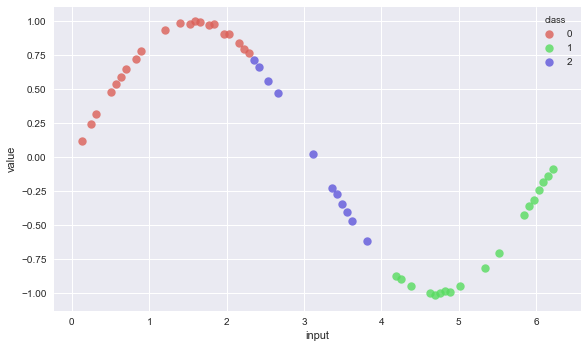

[1 1 1 2 2 1 0 0 0 2 2 0 0 0 0 2 0 0 0 1 1 2 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0
 0 0 0 0 0 2 0 0 2 1 0 0 0]
0.4486153948900545


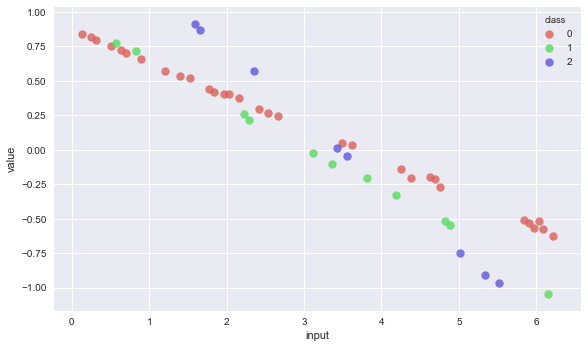

[0 1 0 2 2 2 1 0 1 2 2 0 0 0 2 1 2 0 0 2 0 2 2 2 1 1 1 0 0 0 1 2 1 1 1 1 1
 2 2 0 0 2 0 1 0 0 2 1 0 1]
0.45042233205244975


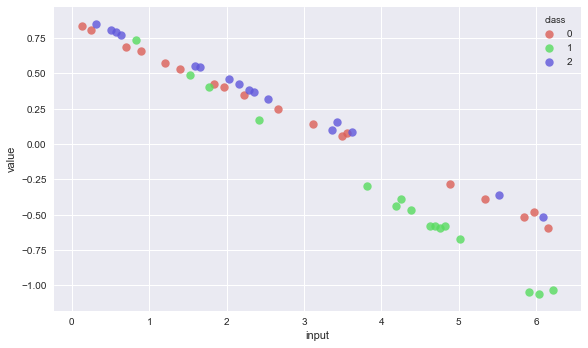

[1 1 1 0 1 2 1 1 0 1 0 1 1 2 0 1 1 2 0 0 0 0 0 0 1 1 2 2 0 0 2 2 0 2 2 1 1
 0 0 0 0 0 1 1 2 0 0 1 0 1]
0.37200915460653433


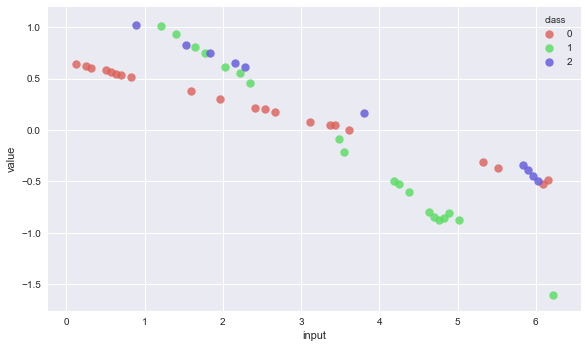

[0 2 1 1 0 0 1 0 0 2 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 1 0 2 1 0 0]
0.46025129796313724


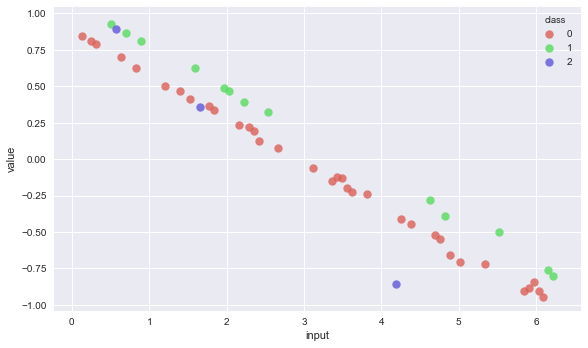

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0]
0.4646847571772314


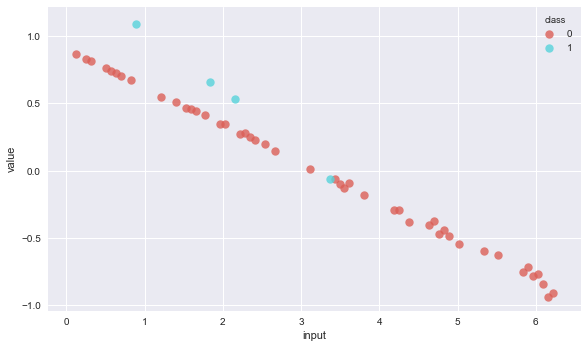

[1 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0
 1 0 0 0 0 1 0 0 1 0 1 1 0]
0.4611926489847143


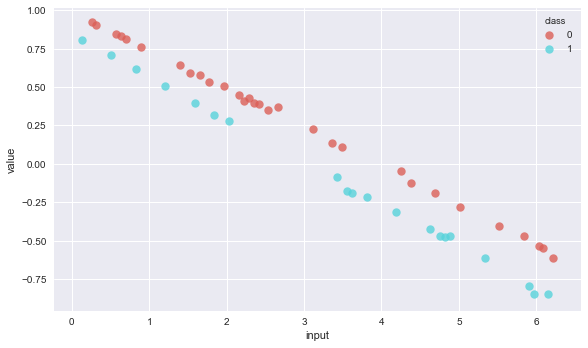

[1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0
 0 0 1 1 0 0 0 0 1 0 1 0 0]
0.4745346360972488


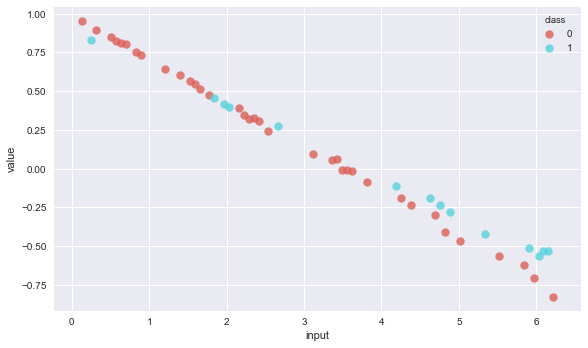

[1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1
 0 0 0 1 1 0 0 0 0 1 0 0 0]
0.44609353948633296


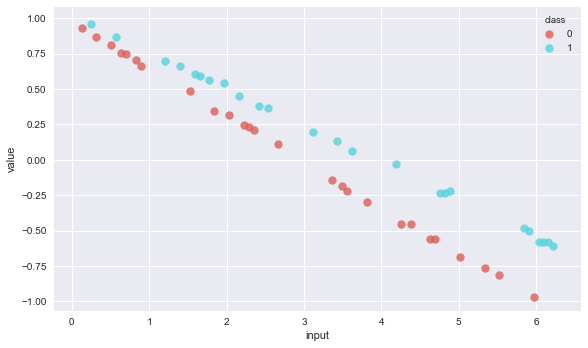

[0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0
 0 1 1 1 0 1 0 0 0 1 0 0 0]
0.467068927652513


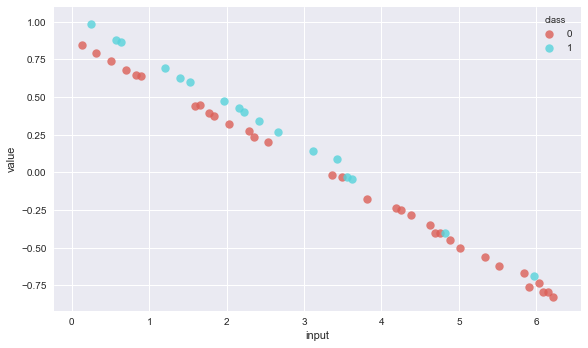

[0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1
 0 0 1 1 1 0 0 0 0 0 0 0 0]
0.3926511350218818


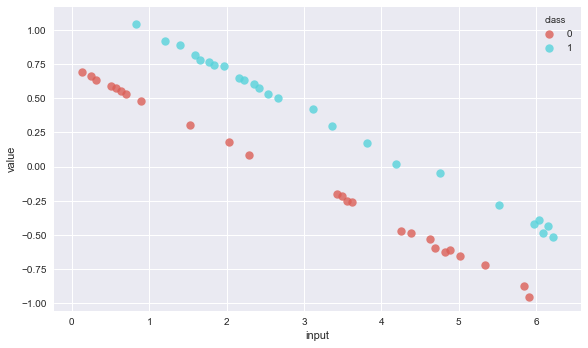

0.3926511350218818


In [27]:
num_task = 3
random.seed(2404)

from sklearn.mixture import GMM
gmm = GMM(n_components=3).fit(X)
T = gmm.predict(X)

fr =pd.DataFrame({'class' : T, 'value': Y, 'input' : X[:, 0]})
plotPoints(fr)


# T = np.random.randint(num_task, size=len(X))
# print(T)
# clf.fit(X, T)
# T = clf.predict(X)
T = MTGPSolver(X, T, Y, 1e-13, 3, 10)



num_task = len(set(T))
PredictionFunctions, Correlations = getFullCorrelation(X, T, Y, num_task)
Y_pred_mean, Y_pred_var = MTGP(X, T, Y, X, T, Correlations , gvar , num_task)
Result = pd.DataFrame(Y_pred_mean)
Result['True'] = np.array(Y)
Result.columns = ['pred', 'True']
diff = Result['pred'] - Result['True']
loss = math.sqrt(np.dot(diff, diff)/len(Result['pred']))
print(loss)


In [6]:
import pandas as pd
import numpy as np
import random 
from matplotlib import pyplot as plt 
import seaborn as sns 

def plotPoints(fr):
    sns.lmplot(x='input' , y='value', data=fr, hue='class',palette='hls', fit_reg=False,size= 5, aspect=5/3, legend_out=False,scatter_kws={"s": 70})
    plt.show()

def plotLine(fr):
    sns.pointplot(x='input' , y='value', data=fr, hue='class',palette='hls', fit_reg=False,size= 5, aspect=5/3, legend_out=False,scatter_kws={"s": 70})
    plt.show()

# fr =pd.DataFrame({'class' : T, 'value': Y, 'input' : X[:, 0]})

# plotPoints(fr)
# # plotLine(fr)


# fr =pd.DataFrame({'class' : T, 'value': Y_pred_mean, 'input' : X[:, 0]})

# plotPoints(fr)
# # plotLine(fr)

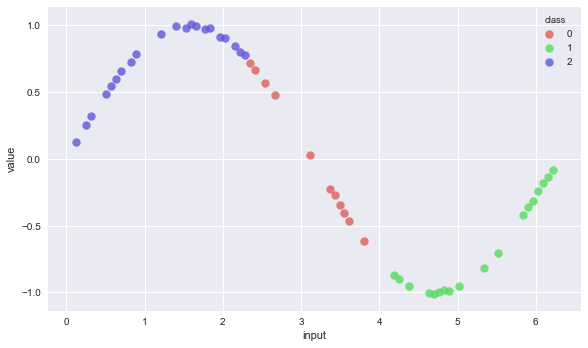

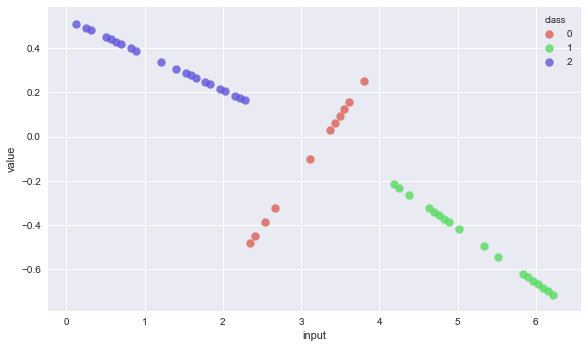

In [13]:
num_task = 3

from sklearn.mixture import GMM
gmm = GMM(n_components=3).fit(X)
T = gmm.predict(X)

num_task = len(set(T))
PredictionFunctions, Correlations = getFullCorrelation(X, T, Y, num_task)

Y_pred_mean, Y_pred_var = MTGP(X, T, Y, X, T, Correlations , 0.01 , num_task)

fr =pd.DataFrame({'class' : T, 'value': Y, 'input' : X[:, 0]})
plotPoints(fr)

fr =pd.DataFrame({'class' : T, 'value': Y_pred_mean, 'input' : X[:, 0]})
plotPoints(fr)


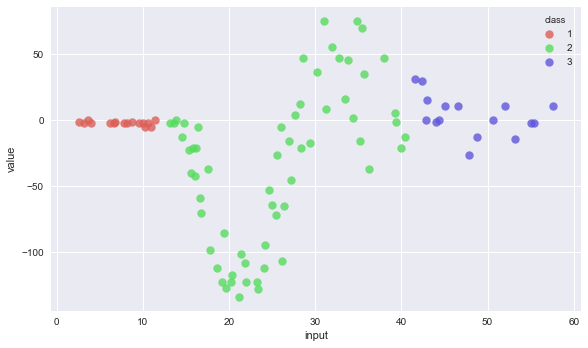

In [15]:
dm = pd.read_csv('Motor.csv')
dm.columns = ['x' , 'y' , 'z' , 'w']

fr =pd.DataFrame({'class' : dm['z'], 'value': dm['y'], 'input' : dm['x']})
plotPoints(fr)